# Original Program in Python


In [2]:
import platform                  # Python 3.9.16
import sys

import numpy             as np   # Numpy 1.23.2
import pandas            as pd   # Pandas 2.0.3
import matplotlib.pyplot as plt
%matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams.update({
    'font.size'     : 16,
    'axes.grid'     : True,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
})
from matplotlib.colors import LogNorm
import seaborn as sns

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Numpy {np.__version__}")

Python Platform: macOS-13.4-arm64-arm-64bit
Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 2.0.3
Numpy 1.23.2


## RNN: forward, TLM and ADJ

### Math function

In [3]:
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x) ** 2

In [4]:
def id(x):
    return x

def id_prime(x):
    return 1

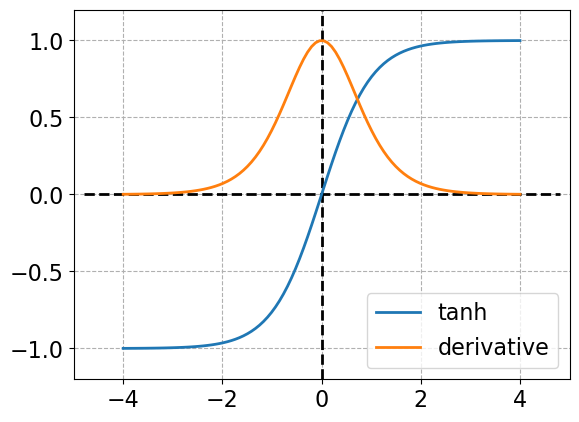

In [5]:
xs = np.linspace(-4, 4, 100)

plt.plot(1.2*xs, 0*xs, "k--")
plt.plot(0*xs, 1.2*(xs)/4, "k--")

plt.plot(xs, tanh(xs),       label="tanh")
plt.plot(xs, tanh_prime(xs), label="derivative")

plt.xlim(-5, 5)
plt.ylim(-1.2, 1.2)
plt.legend(loc="lower right")
plt.show()


### 非線形モデル, TLM, ADJ

ここで実装するのは Elman Network

- Elman, Jeffrey L. (1990). “Finding Structure in Time”. Cognitive Science 14 (2): 179–211. doi:10.1016/0364-0213(90)90002-E.

```
# p: batch num (lag window size, fixed to 1 in this experiment)
# J: feature num = J = 175

# T: Total train data size (= 40 - p)
# Din : Input size (= J x p)
# Drec: Hidden size, n_hidden
# Dout: Output size (feature num = J = 175)
```

RNNcell

$\vec{h}_t = \tanh(\mathrm{W}^{(in)} \vec{x}_t + \mathrm{W}^{(rec)} \vec{h}_{t-1} + \vec{b})$

for $1 \leq t \leq T$

```
    input:
        xt: (Din x 1) <== x[t, :]

        params:
        Win: (Drec x Din)
        Wrec: (Drec x Drec)
        b_rec: (Drec x 1)

        h_prev: (Drec x 1)
    
    output:
        ht: (Drec x 1) <== h[t, :]
```

Affine (Dense)

$\vec{z}_t = \sigma(\mathrm{W}^{(out)} \vec{h}_t + \vec{b}^{(out)})$

```
    input:
        ht:  (Drec x 1)

        params:
        Wout: Dout x Drec
        b_out: Dout x 1
    output: 
        zt: (Dout x 1) <== z[t, :]
```

In [6]:
def RNNstep(xt, h_prev, Win, Wrec, b_rec, Wout, b_out, 
            h_actF=tanh, z_actF=id):
    """
    Compute one step of a recurrent neural network (by Elman 1990)
    input:
        xt    : input vector of shape (Din, 1)           @ input nodes
        h_prev: previous hidden state of shape (Drec, 1) @ hidden nodes

        weights:
        Win   : input-to-hidden weights of shape (Drec, Din)    @ input layer
        Wrec  : hidden-to-hidden weights of shape (Drec, Drec)  @ hidden layer (RNN cell)
        b_rec : biases of shape (Drec, 1)                       @ hidden layer (RNN cell)

        Wout  : hidden-to-output weights of shape (Dout, Drec)  @ output layer (Affine)
        b_out : biases of shape (Dout, 1)                       @ output layer (Affine)

        activation functions:
        h_actF: hidden activation function (sigmoid)
        z_actF: output activation function (3*tanh)
    returns:
        the next hidden state and the output
        ht, zt
    """

    # hidden layer (RNN cell)
    ht = h_actF(Win @ xt + Wrec @ h_prev + b_rec)

    # output layer (Affine)
    zt = z_actF(Wout @ ht + b_out)

    return ht, zt

In [7]:
def RNNstep_tlm(xt,  h_prev,  Win,  Wrec,  b_rec,  Wout,  b_out, 
                dx, dh_prev, dWin, dWrec, db_rec, dWout, db_out, 
                h_actF=tanh, z_actF=id, h_actF_prime=tanh_prime, z_actF_prime=id_prime):
    """
    Compute the tangent linear model of the RNNstep function
    input:
        xt    : input vector of shape (Din, p)           @ input nodes
        h_prev: previous hidden state of shape (Drec, 1) @ hidden nodes

        weights:
        Win   : input-to-hidden weights of shape (Drec, Din)    @ input layer
        Wrec  : hidden-to-hidden weights of shape (drec, drec)  @ hidden layer (RNN cell)
        b_rec : biases of shape (Drec, 1)                       @ hidden layer (RNN cell)

        Wout  : hidden-to-output weights of shape (Dout, Drec)  @ output layer (Affine)
        b_out : biases of shape (Dout, 1)                       @ output layer (Affine)

        perturbations:
        dx, dh_prev, dWin, dWrec, db_rec, dWout, db_out

        activation functions:
        h_actF, h_actF_prime: hidden activation function and its deriverate (sigmoid)
        z_actF, z_actF_prime: output activation function and its deriverate (3*tanh)

    returns:
        the response characteristics of the model
        dz
    """

    # hidden layer (RNN cell)
    w_rec = Win @ xt + Wrec @ h_prev + b_rec
    dw_rec = (dWin @ xt + Win @ dx) + (dWrec @ h_prev + Wrec @ dh_prev) + db_rec
    ht = h_actF(w_rec)
    dh = h_actF_prime(w_rec) * dw_rec

    # output layer (Affine)
    dz = z_actF_prime(Wout @ ht + b_out) * (dWout @ ht + Wout @ dh + db_out)

    return dz

In [8]:
def matrices_to_statespace(matrices):
    """
    Convert the RNNstep matrices to a state space model
    input:
        matrices: list of matrices
        e.g. [xt, h_prev, Win, Wrec, b_rec, Wout, b_out]
    returns:
        the state space vector and the list of matrix.shape
        X, shapes
    """
    
    concat = []
    shapes = []
    for matrix in matrices:
        concat.append(matrix.flatten())
        shapes.append(matrix.shape)
    X = np.concatenate(concat)
    return X, shapes

In [9]:
def statespace_to_matrices(X, shapes):
    """
    Convert the state space model to RNNstep matrices
    input:
        X: state space vector
        shapes: list of matrix.shape
    returns:
        the matrices
        matrices
    """
    
    matrices = []
    i = 0
    for shape in shapes:
        matrices.append(X[i:i+np.prod(shape)].reshape(shape))
        i += np.prod(shape)
    return matrices

### Test


In [14]:
# Define the input and weights
xt = np.array([[0.5], [0.2], [0.8]])
h_prev = np.array([[0.1], [0.3]])
Win = np.array([[0.2, 0.3, 0.1], [0.4, 0.5, 0.6]])
Wrec = np.array([[0.5, 0.4], [0.1, 0.6]])
b_rec = np.array([[0.1], [0.2]])
Wout = np.array([[0.5, 0.4], [0.2, 0.1], [0.7, 0.8]])
b_out = np.array([[0.1], [0.2], [0.4]])

# Call the RNNstep function
ht, zt = RNNstep(xt, h_prev, Win, Wrec, b_rec, Wout, b_out)

# Print the output
print("ht:")
print(ht)
print("zt:")
print(zt)


ht:
[[0.4699452 ]
 [0.82427217]]
zt:
[[0.66468147]
 [0.37641626]
 [1.38837938]]


### Kalman Filter

In [15]:
def get_LzdX(X0, dX, shapes):
    xt,  h_prev,  Win,  Wrec,  b_rec,  Wout,  b_out, = statespace_to_matrices(X0, shapes)
    dxt, dh_prev, dWin, dWrec, db_rec, dWout, db_out = statespace_to_matrices(dX, shapes)
    dz = RNNstep_tlm(xt,  h_prev,  Win,  Wrec,  b_rec,  Wout,  b_out,
                     dxt, dh_prev, dWin, dWrec, db_rec, dWout, db_out)
    return dz

In [16]:
def get_LzU(U, X0, shapes):
    concat = []
    for i in range(U.shape[1]):
        Vi = get_LzdX(X0, U[:,i], shapes)
        concat.append(Vi.reshape(-1,1))
    
    LzU = np.concatenate(concat, axis=1)
    return LzU

In [17]:
def get_tlm(xt: np.ndarray, h_prev: np.ndarray,
             wt: np.ndarray, shapes: list):
    Win, Wrec, b_rec, Wout, b_out = statespace_to_matrices(wt, shapes)
    X0, X0shapes = matrices_to_statespace([xt, h_prev, Win, Wrec, b_rec, Wout, b_out])

    E = np.eye(X0.size)
    TLM = get_LzU(E, X0, X0shapes)

    Lz = TLM[:, :xt.size]
    Lh = TLM[:, xt.size:xt.size+h_prev.size]
    H  = TLM[:, xt.size+h_prev.size:]
    
    return Lz, H

In [18]:
def Hobs(yo_prev: np.ndarray, h_prev, w: np.ndarray, shapes: list):
    Win, Wrec, b_rec, Wout, b_out = statespace_to_matrices(w, shapes)
    
    ht, zt = RNNstep(yo_prev, h_prev, Win, Wrec, b_rec, Wout, b_out)

    return zt

In [19]:
from numpy.linalg import inv

def KalmanFilter(Wa_prev: np.ndarray, Pa_prev: np.ndarray,
                 Wshapes: list,
                 h_prev, yo_prev, H: np.ndarray,
                 yo: np.ndarray, R: np.ndarray):
    J = yo.shape[0]
    Pa_prev = (Pa_prev + Pa_prev.T) / 2 # Ensure P is symmetric

    # Forecast
    Wf = Wa_prev
    Pf = Pa_prev

    # Analysis
    K = Pf @ H.T @ inv(H @ Pf @ H.T + R)

    Wa = Wf + K @ (yo - Hobs(yo_prev, h_prev, Wf, Wshapes))

    I = np.eye(Wa.shape[0])
    Pa = (I - K @ H) @ Pf


    return Pf, Wa, Pa

In [20]:
def Forecast(xt: np.ndarray, h_prev: np.ndarray, Px: np.ndarray,
             wt: np.ndarray, shapes: list,       Pw: np.ndarray, 
             Lz, H):
    
    Win, Wrec, b_rec, Wout, b_out = statespace_to_matrices(wt, shapes)

    # Forecast
    ht, zt = RNNstep(xt, h_prev, Win, Wrec, b_rec, Wout, b_out)

    # Forecast covariance
    Pz = Lz @ Px @ Lz.T + H @ Pw @ H.T

    return ht, zt, Pz

In [25]:
# Define the input and weights
xt = np.array([[0.5], [0.2], [0.8]])
h_prev = np.array([[0.1], [0.3]])
Win = np.array([[0.2, 0.3, 0.1], [0.4, 0.5, 0.6]])
Wrec = np.array([[0.5, 0.4], [0.1, 0.6]])
b_rec = np.array([[0.1], [0.2]])
Wout = np.array([[0.5, 0.4], [0.2, 0.1], [0.7, 0.8]])
b_out = np.array([[0.1], [0.2], [0.4]])

Wa_prev, shapes = matrices_to_statespace([Win, Wrec, b_rec, Wout, b_out])

# Define the initial conditions
yo_prev = np.array([[0.1], [0.2], [0.3]])
h_prev = np.array([[0.1], [0.3]])
Pa_prev = np.eye(6)
Pw = np.eye(Wa_prev.size)
R = 0.1 * np.eye(3)

yo = np.array([[0.2], [0.3], [0.4]])

# Define the observation matrix
Lz, H = get_tlm(xt, h_prev, Wa_prev, shapes)

# Call the KalmanFilter function
Pf, Wa, Pa = KalmanFilter(Wa_prev, Pa_prev, shapes, h_prev, yo_prev, H, yo, R)

# Print the output
print("Pf:")
print(Pf)
print("Wa:")
print(Wa)
print("Pa:")
print(Pa)

# Call the Forecast function
ht, zt, Pz = Forecast(xt, h_prev, R, Wa, shapes, Pa, Lz, H)

# Print the output
print("ht:")
print(ht)
print("zt:")
print(zt)
print("Pz:")
print(Pz)



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 21 is different from 6)

## Assimilation Execute

### Read Data

In [15]:
coef_raw = pd.read_csv("../data/processed/coef.csv")

# make column of name = "letter(n, m)"
coef = coef_raw.iloc[:195, :]

coef["coef"] = coef["letter"] + "(" + coef["n"].astype(str) + ", " + coef["m"].astype(str) + ")"

coef_dfT = coef.loc[:, "2004.75":"2019.50"]

coef_dfT.index = coef["coef"]

coef_df = coef_dfT.T

# インデックスの範囲を設定（2004年から2019年まで3ヶ月ごと）
# start_date, end_date = '2004-10-01', '2019-07-01'
# coef_df.index = pd.date_range(start=start_date, end=end_date, freq="QS")

coef_df.index.name = "YEAR"
coef_df.index = coef_df.index.astype(float)

display(coef_df.head())

/var/folders/m6/3_6_32s90qdf_nhdhwt9413w0000gn/T/ipykernel_171/2695026321.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef["coef"] = coef["letter"] + "(" + coef["n"].astype(str) + ", " + coef["m"].astype(str) + ")"


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2004.75,-29555.37,-1672.562,5083.327,-2333.885,3048.621,-2588.899,1657.819,-512.5044,1336.003,-2304.827,...,0.347673,0.527706,-0.051912,0.394486,0.407936,-0.237999,-0.119698,-0.569100,-0.187342,-0.839604
2005.00,-29552.40,-1669.005,5077.600,-2336.995,3047.363,-2594.429,1657.606,-515.2604,1336.067,-2305.820,...,0.350986,0.526671,-0.048617,0.396378,0.411378,-0.238317,-0.127115,-0.565939,-0.189713,-0.841823
2005.25,-29549.40,-1665.296,5071.916,-2340.096,3046.127,-2599.968,1657.490,-517.9986,1336.115,-2306.836,...,0.354162,0.525783,-0.045149,0.398017,0.415089,-0.238496,-0.134140,-0.562783,-0.191866,-0.843815
2005.50,-29546.44,-1661.573,5066.217,-2343.176,3044.880,-2605.541,1657.489,-520.7021,1336.181,-2307.883,...,0.357142,0.525001,-0.041508,0.399368,0.418995,-0.238459,-0.140693,-0.559620,-0.193851,-0.845491
2005.75,-29543.48,-1657.719,5060.500,-2346.239,3043.621,-2611.204,1657.564,-523.3253,1336.234,-2308.959,...,0.359874,0.524350,-0.037673,0.400387,0.423086,-0.238180,-0.146799,-0.556445,-0.195654,-0.846816


In [16]:
cvar_raw = pd.read_csv("../data/processed/cvar.csv")

# make column of name = "letter(n, m)"
cvar = cvar_raw.iloc[:195, :]

cvar["coef"] = cvar["letter"] + "(" + cvar["n"].astype(str) + ", " + cvar["m"].astype(str) + ")"

cvar_dfT = cvar.loc[:, "2004.75":"2019.50"]

cvar_dfT.index = cvar["coef"]

cvar_df = cvar_dfT.T

# インデックスの範囲を設定（2004年から2019年まで3ヶ月ごと）
# start_date, end_date = '2004-10-01', '2019-07-01'
# coef_df.index = pd.date_range(start=start_date, end=end_date, freq="QS")

cvar_df.index.name = "YEAR"
cvar_df.index = cvar_df.index.astype(float)

display(cvar_df.head())

/var/folders/m6/3_6_32s90qdf_nhdhwt9413w0000gn/T/ipykernel_171/916716676.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvar["coef"] = cvar["letter"] + "(" + cvar["n"].astype(str) + ", " + cvar["m"].astype(str) + ")"


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2004.75,0.041781,0.020475,0.025262,0.015275,0.007163,0.005497,0.007152,0.008494,0.004517,0.003525,...,0.000006,0.000006,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2005.00,0.041776,0.020476,0.025262,0.015271,0.007160,0.005494,0.007155,0.008492,0.004513,0.003521,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2005.25,0.041759,0.020443,0.025241,0.015256,0.007142,0.005468,0.007137,0.008474,0.004502,0.003509,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2005.50,0.041748,0.020437,0.025237,0.015246,0.007138,0.005471,0.007135,0.008473,0.004495,0.003504,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2005.75,0.041740,0.020436,0.025236,0.015239,0.007136,0.005476,0.007136,0.008472,0.004490,0.003501,...,0.000005,0.000005,0.000005,0.000005,0.000004,0.000004,0.000005,0.000004,0.000005,0.000005


### make differential data

In [17]:
g        = coef_df
dg_dt    = g    .diff(1, "index").dropna() * 4
ddg_dtdt = dg_dt.diff(1, "index").dropna() * 4

diff = [g, dg_dt, ddg_dtdt]

display(ddg_dtdt.head())

coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2005.25,4.800000e-01,2.432,0.688,0.144,0.352,-0.144,1.552,0.2848,-0.256,-0.368,...,-0.002179,0.002355,0.002771,-0.004040,0.004299,0.002221,0.006253,-0.000074,0.003506,0.003624
2005.50,-6.400000e-01,0.224,-0.240,0.336,-0.176,-0.544,1.840,0.5552,0.288,-0.496,...,-0.003134,0.001706,0.002762,-0.004614,0.003133,0.003453,0.007566,0.000114,0.002672,0.005078
2005.75,-5.820766e-11,2.096,-0.288,0.272,-0.192,-1.440,1.216,1.2848,-0.208,-0.464,...,-0.003963,0.002091,0.003095,-0.005301,0.002952,0.003861,0.007141,0.000178,0.002925,0.005594
2006.00,-1.600000e-01,1.296,-0.624,-0.160,0.112,0.416,2.480,-0.0128,-0.256,-0.304,...,-0.003422,0.001208,0.003363,-0.005501,0.002765,0.004013,0.007355,0.000792,0.002894,0.006291
2006.25,6.400000e-01,1.712,-0.416,0.064,0.352,-0.048,2.368,-0.0800,-0.160,0.128,...,-0.003504,0.000621,0.003044,-0.005550,0.001325,0.003357,0.008469,0.001170,0.002325,0.007387


In [18]:
def create_train_valid(input_df: pd.DataFrame):
    transformer_df = pd.DataFrame(index=["min_val", "max_val", "scale"], columns=input_df.columns)
    scaled_df = pd.DataFrame(index=input_df.index, columns=input_df.columns)

    for col in input_df.columns:
        min_val, max_val = input_df[col].min(), input_df[col].max()
        scale = max_val - min_val

        transformer_df.loc["min_val", col] = min_val
        transformer_df.loc["max_val", col] = max_val
        transformer_df.loc["scale",   col] = scale

        scaled_df[col] = (input_df[col] - min_val) / scale

    train_df = scaled_df.loc[2004.75:2014.50, :]
    test_df  = scaled_df.loc[2014.75:2019.50, :]

    # train_size, test_size = len(train_df), len(test_df)

    # display(train_df)
    # display(test_df)

    train_df = input_df.loc[2004.75:2014.50, :]
    test_df  = input_df.loc[2014.75:2019.50, :]
    transformer_df = None

    return train_df, test_df, transformer_df

In [19]:
train, valid, transformer, train_size, test_size = [[None, None, None, None, None] for _ in range(5)]

for d in range(3):
    input_df = diff[d]
    train[d], valid[d], transformer[d] =  create_train_valid(input_df)
    train_size[d], test_size[d] = len(train[d]), len(valid[d])


In [20]:
R = []

for ti in cvar_df.index:
    sigma2 = cvar_df.loc[ti, :].values
    Rt = np.diag(sigma2)
    R.append((ti, Rt))

Rp = []
for i in range(len(R)):
    if i-1 < 0:
        Rp.append((R[i][0], None))
        continue

    Rpt = (R[i][1] + R[i-1][1]) * 4**2
    Rp.append((R[i][0], Rpt))

Rpp = []
for i in range(len(R)):
    if i-2 < 0:
        Rpp.append((R[i][0], None))
        continue

    Rppt = (R[i][1] + 4 * R[i-1][1] + R[i-2][1]) * 4**4
    Rpp.append((R[i][0], Rppt))

print(Rpp[0])
print(Rpp[1])
print(Rpp[2])

train_var, test_var = [[None, None, None, None, None] for _ in range(2)]

for d in range(3):
    cvar_d_df = pd.DataFrame(index=cvar_df.index, columns=cvar_df.columns)

    Rd = [R, Rp, Rpp][d]

    for Rdt in (Rd):
        if Rdt[1] is None:
            continue
        
        ti, sigma2 = Rdt[0], np.diag(Rdt[1]).reshape(-1)
        # print(ti, sigma2)
        cvar_d_df.loc[ti, :] = sigma2
    
    cvar_d_df.dropna(inplace=True)
    cvar_d_df = cvar_d_df.astype(float)

    train_var[d] = cvar_d_df.loc[2004.75:2014.50, :]
    test_var[d]  = cvar_d_df.loc[2014.75:2019.50, :]

display(train_var[0].head())
display(train_var[1].head())
display(train_var[2].head())
display(train_var[2].describe())

(2004.75, None)
(2005.0, None)
(2005.25, array([[6.41646490e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.14423578e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.87967078e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.68457498e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.81464576e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.81509453e-03]]))


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2004.75,0.041781,0.020475,0.025262,0.015275,0.007163,0.005497,0.007152,0.008494,0.004517,0.003525,...,0.000006,0.000006,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2005.00,0.041776,0.020476,0.025262,0.015271,0.007160,0.005494,0.007155,0.008492,0.004513,0.003521,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2005.25,0.041759,0.020443,0.025241,0.015256,0.007142,0.005468,0.007137,0.008474,0.004502,0.003509,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2005.50,0.041748,0.020437,0.025237,0.015246,0.007138,0.005471,0.007135,0.008473,0.004495,0.003504,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2005.75,0.041740,0.020436,0.025236,0.015239,0.007136,0.005476,0.007136,0.008472,0.004490,0.003501,...,0.000005,0.000005,0.000005,0.000005,0.000004,0.000004,0.000005,0.000004,0.000005,0.000005


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2005.00,1.336913,0.655211,0.808380,0.488740,0.229170,0.175862,0.228907,0.271774,0.144485,0.112736,...,0.000174,0.000173,0.000165,0.000165,0.000163,0.000163,0.000164,0.000164,0.000166,0.000166
2005.25,1.336553,0.654702,0.808043,0.488429,0.228836,0.175397,0.228656,0.271445,0.144234,0.112473,...,0.000167,0.000166,0.000158,0.000158,0.000157,0.000156,0.000157,0.000157,0.000159,0.000159
2005.50,1.336114,0.654073,0.807642,0.488039,0.228474,0.175026,0.228338,0.271147,0.143944,0.112203,...,0.000161,0.000160,0.000152,0.000153,0.000151,0.000151,0.000151,0.000151,0.000154,0.000154
2005.75,1.335808,0.653959,0.807566,0.487775,0.228380,0.175150,0.228323,0.271127,0.143756,0.112074,...,0.000155,0.000155,0.000147,0.000148,0.000146,0.000146,0.000146,0.000146,0.000149,0.000149
2006.00,1.335440,0.653430,0.807227,0.487481,0.228048,0.174859,0.228049,0.270876,0.143535,0.111856,...,0.000151,0.000151,0.000143,0.000143,0.000142,0.000142,0.000142,0.000142,0.000144,0.000145


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2005.25,64.164649,31.442358,38.796708,23.453348,10.994175,8.433065,10.984117,13.039238,6.930186,5.406063,...,0.008161,0.008154,0.007756,0.007754,0.007675,0.007668,0.007687,0.007685,0.007815,0.007815
2005.50,64.143186,31.407094,38.774387,23.434540,10.973602,8.406542,10.965812,13.019982,6.915616,5.391266,...,0.007847,0.007843,0.007455,0.007456,0.007377,0.007371,0.007391,0.007389,0.007507,0.007508
2005.75,64.125857,31.392179,38.764426,23.419190,10.964157,8.403867,10.959499,13.014553,6.904611,5.382504,...,0.007574,0.007573,0.007196,0.007199,0.007122,0.007117,0.007138,0.007135,0.007249,0.007251
2006.00,64.110674,31.381268,38.757727,23.406702,10.956526,8.403880,10.955354,13.009926,6.895453,5.375181,...,0.007336,0.007337,0.006972,0.006976,0.006903,0.006899,0.006919,0.006915,0.007031,0.007035
2006.25,64.091909,31.344991,38.733084,23.391450,10.933619,8.378103,10.935078,12.993421,6.883849,5.362535,...,0.007125,0.007129,0.006776,0.006780,0.006712,0.006710,0.006729,0.006724,0.006846,0.006853


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,64.241099,31.499675,38.868580,23.516287,11.019611,8.458821,11.039113,13.098106,6.947332,5.431538,...,0.007208,0.007220,0.007069,0.007053,0.007130,0.007170,0.007122,0.007075,0.007636,0.007686
std,0.220094,0.214250,0.197411,0.176529,0.134338,0.129141,0.149581,0.146653,0.093310,0.103556,...,0.000870,0.000857,0.000971,0.000952,0.001046,0.001067,0.001029,0.001002,0.001346,0.001369
min,64.034578,31.301719,38.684534,23.351196,10.893949,8.327344,10.900191,12.960119,6.851918,5.334242,...,0.006141,0.006164,0.005927,0.005929,0.005924,0.005949,0.005924,0.005900,0.006179,0.006215
25%,64.073592,31.331834,38.714799,23.376737,10.913543,8.357320,10.921674,12.981329,6.871895,5.351575,...,0.006401,0.006418,0.006175,0.006175,0.006181,0.006198,0.006189,0.006166,0.006451,0.006476
50%,64.124649,31.386724,38.761076,23.426495,10.958897,8.398374,10.957426,13.017267,6.903138,5.381094,...,0.007057,0.007075,0.006850,0.006844,0.006870,0.006894,0.006875,0.006844,0.007204,0.007236
75%,64.443741,31.702049,39.063986,23.662696,11.134300,8.583752,11.183586,13.228583,7.027649,5.518905,...,0.007966,0.007988,0.007847,0.007814,0.007993,0.008059,0.007983,0.007897,0.008780,0.008853
max,64.652163,31.899052,39.231532,23.849124,11.281541,8.703804,11.317327,13.379303,7.120827,5.633862,...,0.008701,0.008649,0.008770,0.008736,0.008974,0.009059,0.008900,0.008812,0.010124,0.010227


In [21]:
def plot_train_valid(d, ax, target):

    ax.plot(train[d].index, train[d][target], c="C0", label="Training data")
    ax.plot(valid[d].index, valid[d][target], c="k",  label="Validation answer")

    ax.fill_between(train[d].index, 
                    train[d][target] - np.sqrt(train_var[d][target]), 
                    train[d][target] + np.sqrt(train_var[d][target]), 
                    color='cyan', alpha=0.5)
    ax.fill_between(valid[d].index,
                    valid[d][target] - np.sqrt(test_var[d][target]), 
                    valid[d][target] + np.sqrt(test_var[d][target]), 
                    color='gray', alpha=0.5)
    
    ymin, ymax = ax.get_ylim()
    ax.fill_between(valid[0].index, ymin, ymax, color='yellow', alpha=0.5) # colorize forecast target period
    
    ax.grid(True)

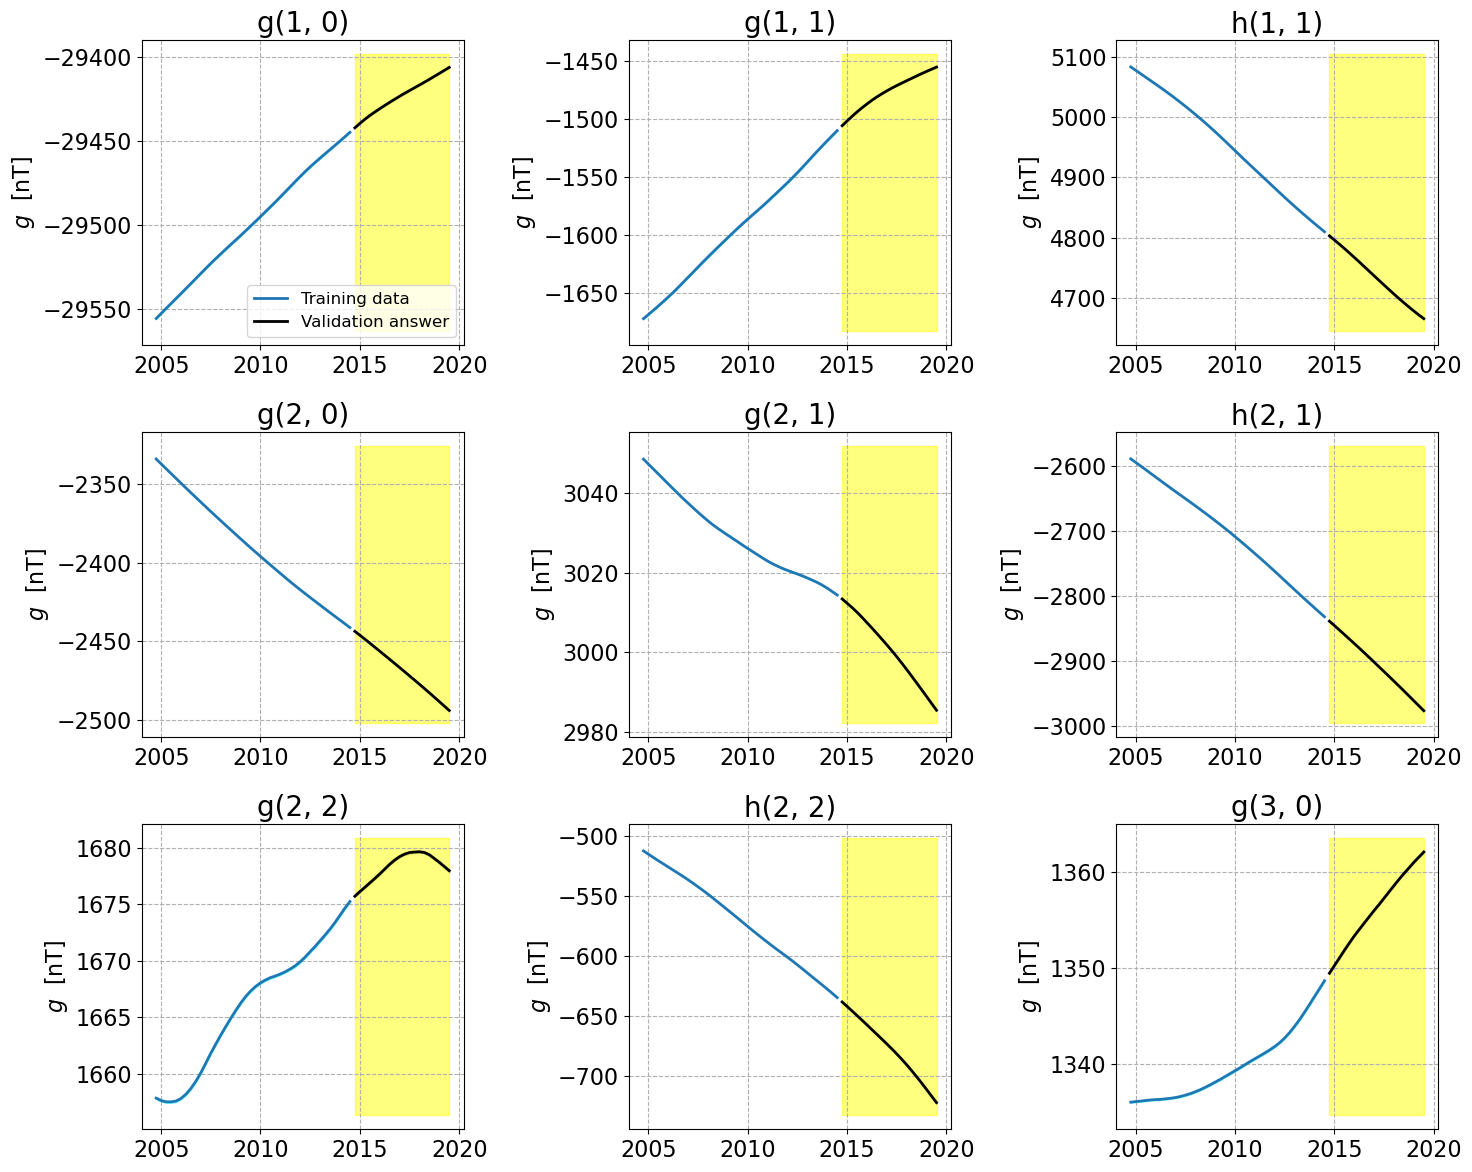

In [22]:
d=0

fig = plt.figure(figsize=(15,12))

fig.subplots_adjust(wspace=0.3, hspace=0.3)

figlocs = [331, 332, 333, 334, 335, 336, 337, 338, 339]
axes = [plt.subplot(figloc) for figloc in figlocs]
coef_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, ax in enumerate(axes):
    idx = coef_idx[i]
    target = coef_df.columns[idx-1]

    plot_train_valid(d, ax, target)

    ax.set_ylabel(f"$g$  [nT]")
    ax.set_title(target, fontsize=20)

axes[0].legend(loc='lower right', fontsize=12)

plt.tight_layout()
# plt.savefig(savedir + "1_train_test_d0g.png")
plt.show()

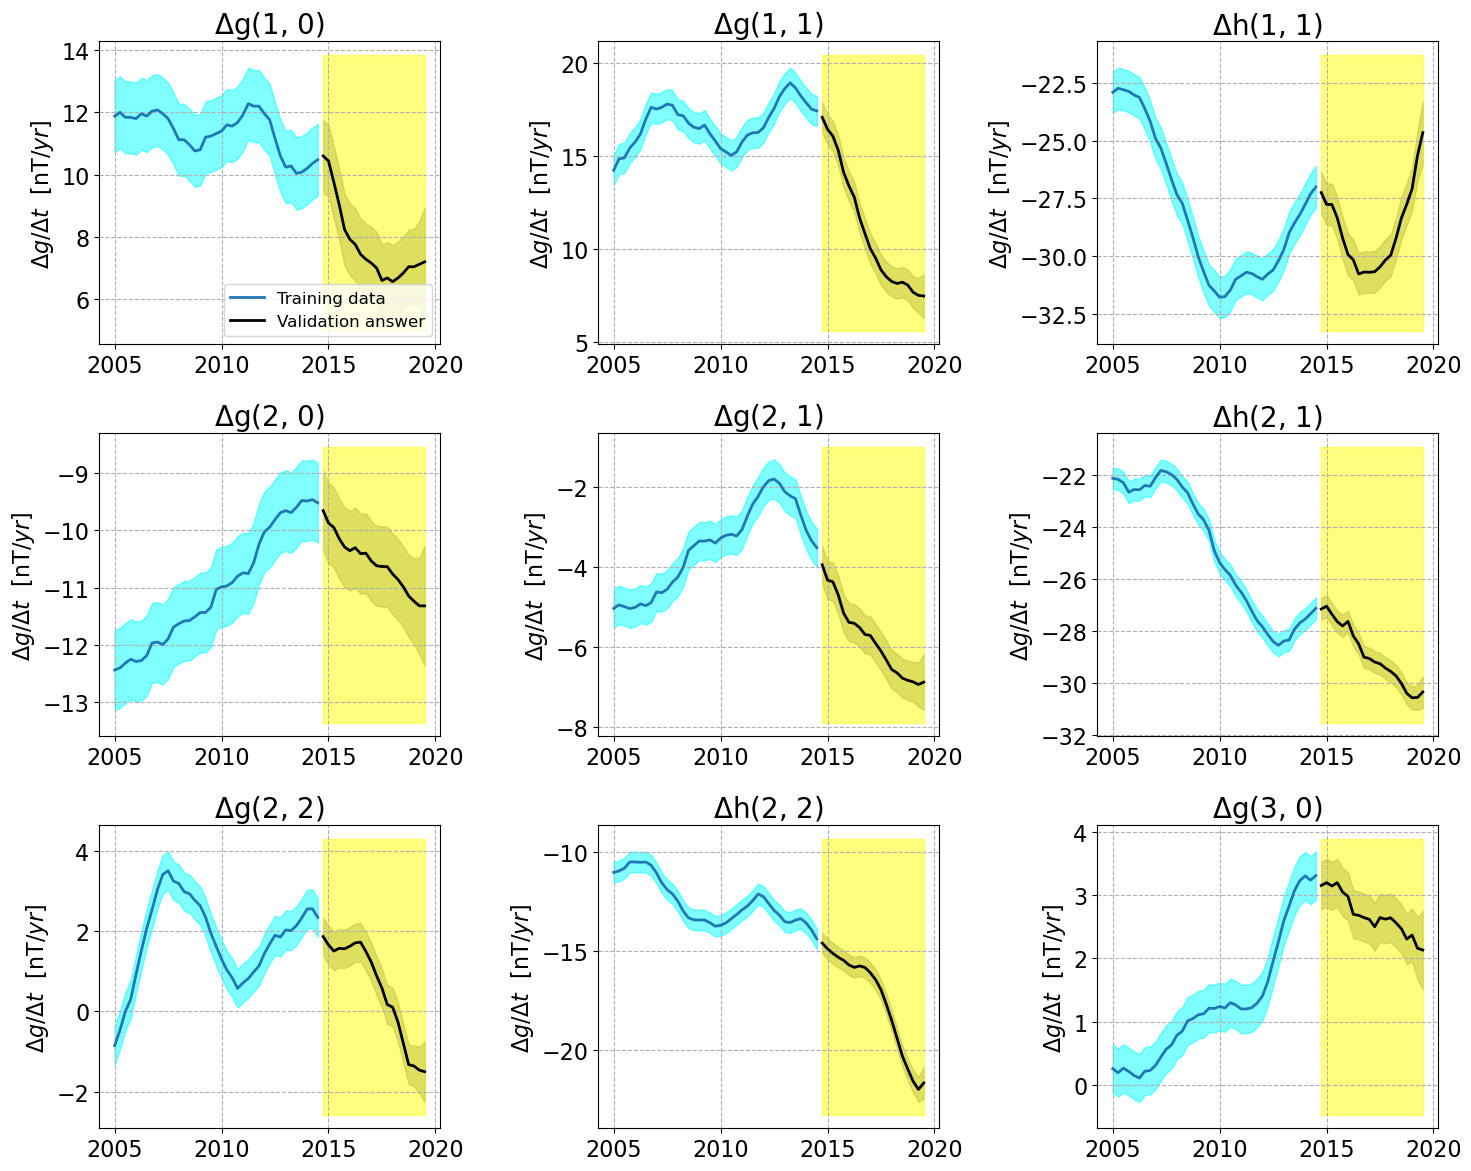

In [23]:
d=1

fig = plt.figure(figsize=(15,12))

fig.subplots_adjust(wspace=0.3, hspace=0.3)

figlocs = [331, 332, 333, 334, 335, 336, 337, 338, 339]
axes = [plt.subplot(figloc) for figloc in figlocs]
coef_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, ax in enumerate(axes):
    idx = coef_idx[i]
    target = coef_df.columns[idx-1]

    plot_train_valid(d, ax, target)

    ax.set_ylabel(f"$\Delta g / \Delta t$  [nT/$yr$]")
    ax.set_title(r"$\Delta$" + target, fontsize=20)


axes[0].legend(loc='lower right', fontsize=12)

plt.tight_layout()
# plt.savefig(savedir + "1_train_test_d1g.png")
plt.show()

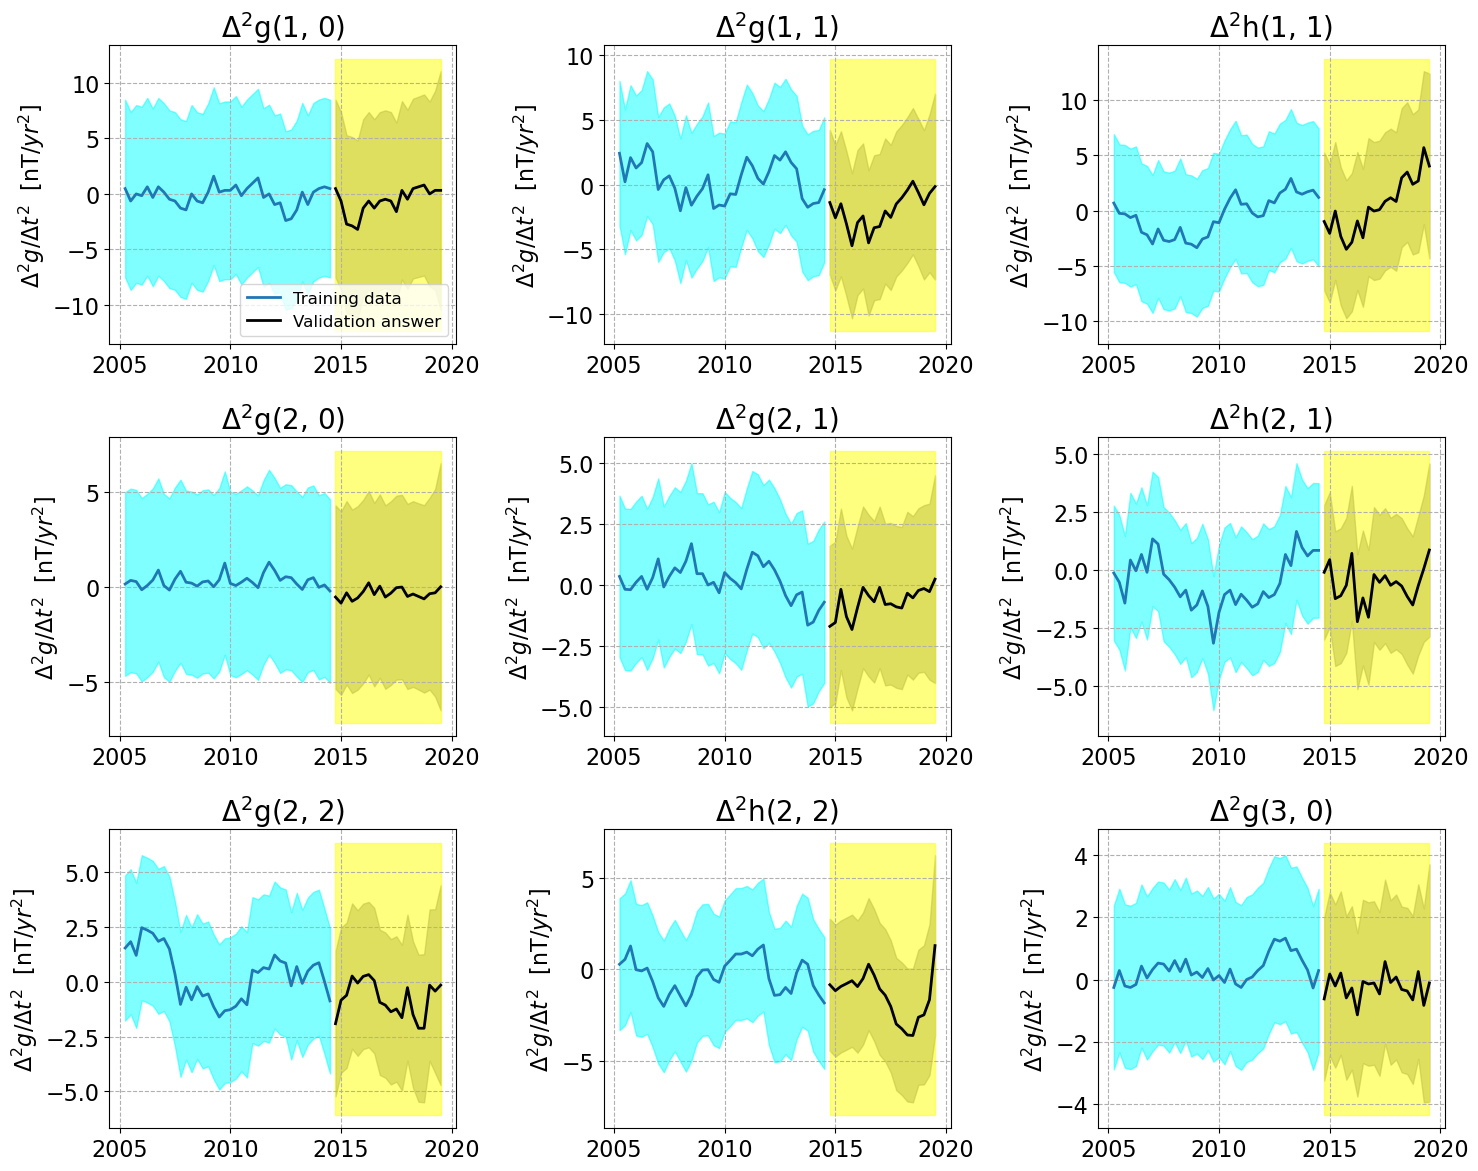

In [24]:
d=2

fig = plt.figure(figsize=(15,12))

fig.subplots_adjust(wspace=0.3, hspace=0.3)

figlocs = [331, 332, 333, 334, 335, 336, 337, 338, 339]
axes = [plt.subplot(figloc) for figloc in figlocs]
coef_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, ax in enumerate(axes):
    idx = coef_idx[i]
    target = coef_df.columns[idx-1]

    plot_train_valid(d, ax, target)


    ax.set_ylabel(f"$\Delta^{2} g / \Delta t ^{2}$  [nT/$yr^2$]")
    ax.set_title(r"$\Delta^2$" + target, fontsize=20)


axes[0].legend(loc='lower right', fontsize=12)

plt.tight_layout()
# plt.savefig(savedir + "1_train_test_d2g.png")
plt.show()

## EKF training and Forecast

In [25]:
# p = 1 so confusing!
d = 2
J = 195 # 195個の gauss 係数
n_hidden = 20

Din = 1 * J
Drec = n_hidden
Dout = J

rng = np.random.RandomState(42 + 1)
mean, stddev = 0.0, 0.05

ht0 = np.zeros(Drec)
Win0 = rng.normal(mean, stddev, (Drec, Din))
Wrec0 = rng.normal(mean, stddev, (Drec, Drec))
b_rec0 = rng.normal(mean, stddev, Drec)

Wout0 = rng.normal(mean, stddev, (Dout, Drec))
b_out0 = rng.normal(mean, stddev, Dout)



In [26]:
print(Rpp[2])

(2005.25, array([[6.41646490e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.14423578e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.87967078e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.68457498e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.81464576e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.81509453e-03]]))


In [27]:
print("calculation start")
RTPS_a = 0.5 # according to Puskorius & Feldcamp we have to use additive inflation!
# additive_eta = 0.001

matrices = [Win0, Wrec0, b_rec0, Wout0, b_out0]

w0, Wshapes = matrices_to_statespace(matrices)
Pa0 = 100 * np.eye(w0.size)
# Q = additive_eta * np.eye(w0.size)
# noise = rng.multivariate_normal(np.zeros(w0.size), Q, size=train_size[d])


Wa_memo, Pa_memo = [w0], [Pa0]
# Winf_memo, Pf_memo, Pinf_memo = [w0], [Pa0], [Pa0] ## for monitoring use only

yo0 = train[d].iloc[0, :].values.reshape(-1)
Rd = [R, Rp, Rpp][d]
time0, Rd0 = Rd[d]

Zf_train, Pz_train = [yo0], [Rd0]

time = diff[d].index
Winf, Pinf = w0, Pa0
ht = ht0

for i in range(1, train_size[d]):
    Rd_time, Rt = Rd[d+i]
    print(f"i = {i}; time = {time[i]}, Rd_time = {Rd_time}, Rt[0, 0] = {Rt[0, 0]}")

    yo_crnt = train[d].iloc[i,   :].values.reshape(-1)
    yo_prev = train[d].iloc[i-1, :].values.reshape(-1)

    Lz, H = get_tlm(yo_prev, ht, Winf, Wshapes)

    Pf, Wa, Pa = KalmanFilter(Winf, Pinf, 
                              Wshapes, 
                              ht, yo_prev, H,
                              yo_crnt, Rt)
    

    Pinf = RTPS_a * Pf + (1 - RTPS_a) * Pa
    # Winf = Wa + noise[i] # Maybe not correct
    Winf = Wa + 0
    # Pinf = Pa + Q

    Wa_memo.append(Wa)
    Pa_memo.append(Pa)
    # Pf_memo.append(Pf)
    # Winf_memo.append(Winf)
    # Pinf_memo.append(Pinf)

    Pf_syn   = np.linalg.norm(Pf - Pf.T)
    Pa_syn   = np.linalg.norm(Pa - Pa.T)
    Pinf_syn = np.linalg.norm(Pinf - Pinf.T)
    if Pf_syn > 1e-10:
        print(f"CAUTION! Pf is not symmetric: {Pf_syn}")
    if Pa_syn > 1e-10:
        print(f"CAUTION! Pa is not symmetric: {Pa_syn}")
    if Pinf_syn > 1e-10:
        print(f"CAUTION! Pinf is not symmetric: {Pinf_syn}")


    ht, zt, Pz = Forecast(yo_prev, ht, Rt, Wa, Wshapes, Pa, Lz, H)

    Zf_train.append(zt)
    Pz_train.append(Pz)

    print(f"Pa = {Pa[0, 0]}, Pf = {Pf[0, 0]}, Pinf = {Pinf[0, 0]}, Pz = {Pz[0, 0]}")


calculation start
i = 1; time = 2005.5, Rd_time = 2005.5, Rt[0, 0] = 64.14318592000001
Pa = 98.88833615488156, Pf = 100.0, Pinf = 99.44416807744078, Pz = 44.09213838455414
i = 2; time = 2005.75, Rd_time = 2005.75, Rt[0, 0] = 64.12585727999999
Pa = 95.37107965229592, Pf = 99.44416807744078, Pinf = 97.40762386486836, Pz = 45.30806636463262
i = 3; time = 2006.0, Rd_time = 2006.0, Rt[0, 0] = 64.11067392000001
Pa = 97.29900584855956, Pf = 97.40762386486836, Pinf = 97.35331485671395, Pz = 52.418691817786815
i = 4; time = 2006.25, Rd_time = 2006.25, Rt[0, 0] = 64.09190912
Pa = 97.29240272087645, Pf = 97.35331485671395, Pinf = 97.3228587887952, Pz = 45.92332887540046
i = 5; time = 2006.5, Rd_time = 2006.5, Rt[0, 0] = 64.08162304
Pa = 93.62556338566637, Pf = 97.3228587887952, Pinf = 95.47421108723078, Pz = 48.1881453791671
i = 6; time = 2006.75, Rd_time = 2006.75, Rt[0, 0] = 64.08183296
Pa = 93.38821991114429, Pf = 95.47421108723078, Pinf = 94.43121549918754, Pz = 47.97244766133279
i = 7; time 

In [28]:
### get W_hat and P_hat
W_hat = Wa_memo[-1]
P_hat = Pa_memo[-1]
for j in range(5):
    if j == 0:
        continue
    print(j)
    Wj, Pj = Wa_memo[-j], Pa_memo[-j]
    W_hat = Pj @ inv(P_hat + Pj) @ W_hat + P_hat @ inv(P_hat + Pj) @ Wj
    P_hat = P_hat @ inv(P_hat + Pj) @ Pj

print(W_hat)
print(P_hat)

1
2
3
4
[ 0.00689641 -0.12198127  0.03389611 ... -0.05028688 -0.08949944
 -0.04643029]
[[ 9.45027142e+00 -1.97476623e-01 -3.77067730e-01 ... -1.35341467e-02
   1.86765190e-02  3.79587393e-02]
 [-1.97476623e-01  6.37754052e+00 -2.45778318e-01 ...  2.87570787e-02
  -1.64789320e-03  1.96781304e-02]
 [-3.77067730e-01 -2.45778318e-01  8.04423324e+00 ... -1.70368963e-02
   2.13903403e-02 -6.60137659e-02]
 ...
 [-1.35341467e-02  2.87570787e-02 -1.70368963e-02 ...  3.59325368e+00
  -6.82024647e-02  7.01538541e-03]
 [ 1.86765190e-02 -1.64789320e-03  2.13903403e-02 ... -6.82024647e-02
   3.69366215e+00  3.16684107e-01]
 [ 3.79587393e-02  1.96781304e-02 -6.60137659e-02 ...  7.01538541e-03
   3.16684107e-01  3.82241099e+00]]


In [29]:
zt, Pz = Zf_train[-1], Pz_train[-1]
Zf_valid, Pz_valid = [zt], [Pz]

for j in range(1, test_size[d]):
    print(f"j = {j}; time = {time[i + j]}")
    ht, zt, Pz = Forecast(zt, ht, Pz, 
                          W_hat, Wshapes, P_hat, 
                          Lz, H)

    Pz_syn = np.linalg.norm(Pz - Pz.T)
    if Pz_syn > 1e-10:
        print(f"CAUTION! Pz is not symmetric: {Pz_syn}")

    Wa_memo.append(W_hat)
    Pa_memo.append(P_hat)
    # Pinf_memo.append(Pa)

    Zf_valid.append(zt)
    Pz_valid.append(Pz)
    print(f"Pa = {Pa[0, 0]}, Pz = {Pz[0, 0]}")

j = 1; time = 2014.75
Pa = 51.24124364831539, Pz = 20.59715213790123
j = 2; time = 2015.0
Pa = 51.24124364831539, Pz = 21.051314944105464
j = 3; time = 2015.25
Pa = 51.24124364831539, Pz = 20.983268368935992
j = 4; time = 2015.5
Pa = 51.24124364831539, Pz = 20.409558395991663
j = 5; time = 2015.75
Pa = 51.24124364831539, Pz = 20.24865276051769
j = 6; time = 2016.0
Pa = 51.24124364831539, Pz = 20.303643188732707
j = 7; time = 2016.25
Pa = 51.24124364831539, Pz = 20.323346960965157
j = 8; time = 2016.5
Pa = 51.24124364831539, Pz = 20.342946688385968
j = 9; time = 2016.75
Pa = 51.24124364831539, Pz = 20.362364970675944
j = 10; time = 2017.0
Pa = 51.24124364831539, Pz = 20.357690364933923
j = 11; time = 2017.25
Pa = 51.24124364831539, Pz = 20.33379698143074
j = 12; time = 2017.5
Pa = 51.24124364831539, Pz = 20.3332638151036
j = 13; time = 2017.75
Pa = 51.24124364831539, Pz = 20.359137444418383
j = 14; time = 2018.0
Pa = 51.24124364831539, Pz = 20.376856849629654
j = 15; time = 2018.25
Pa =

## Integrate Results

In [30]:
def integrate(Y0: float, dY: np.ndarray)->np.ndarray:
    Y = np.zeros(len(dY) + 1)

    Y[0] = Y0
    for i in range(len(dY)):
        Y[i + 1] = Y[i] + dY[i]
    
    return Y[1:]

In [31]:
### coef

d2g_train = pd.DataFrame(Zf_train, index=train[d].index, columns=train[d].columns)
d2g_valid = pd.DataFrame(Zf_valid, index=valid[d].index, columns=valid[d].columns)

d1g_train = pd.DataFrame(index=train[d].index, columns=train[d].columns)
d1g_valid = pd.DataFrame(index=valid[d].index, columns=valid[d].columns)

d0g_train = pd.DataFrame(index=train[d].index, columns=train[d].columns)
d0g_valid = pd.DataFrame(index=valid[d].index, columns=valid[d].columns)

train0_epoch = train[d].index[0] # = 2005.25
valid0_epoch = train[d].index[-1] # = 2014.50
for target in valid[d].columns:
    # min_val, max_val, scale = transformer[d][target]
    train_result = d2g_train[target].values # * scale + min_val
    valid_result = d2g_valid[target].values # * scale + min_val

    d2g_train[target] = train_result
    d2g_valid[target] = valid_result

    ### integrate
    train_pre = diff[1].loc[train0_epoch-0.25 : valid0_epoch-0.25, target].values
    train_result = train_pre + train_result*0.25 # dY = dg/dt * dt
    valid_result = integrate(diff[1][target].loc[valid0_epoch], valid_result*0.25)

    d1g_train[target] = train_result
    d1g_valid[target] = valid_result

    train_pre = diff[0].loc[train0_epoch-0.25 : valid0_epoch-0.25, target].values
    train_result = train_pre + train_result*0.25 # dY = dg/dt * dt
    valid_result = integrate(diff[0][target].loc[valid0_epoch], valid_result*0.25)

    d0g_train[target] = train_result
    d0g_valid[target]  = valid_result


In [32]:
### cvar
d2g_train_cvar = pd.DataFrame(index=train[d].index, columns=train[d].columns)
d2g_valid_cvar = pd.DataFrame(index=valid[d].index, columns=valid[d].columns)

d1g_train_cvar = pd.DataFrame(index=train[d].index, columns=train[d].columns)
d1g_valid_cvar = pd.DataFrame(index=valid[d].index, columns=valid[d].columns)

d0g_train_cvar = pd.DataFrame(index=train[d].index, columns=train[d].columns)
d0g_valid_cvar = pd.DataFrame(index=valid[d].index, columns=valid[d].columns)

for i, ti in enumerate(train[d].index[1:]):
    print(f"i = {i}; time = {ti}")
    d2g_train_cvar.loc[ti, :] = np.diag(Pz_train[i])

Rp_rel = Rp[-1][1]
d1g_cvar = np.diag(Rp_rel)
R_rel = R[-1][1]
d0g_cvar = np.diag(R_rel)

for j, tj in enumerate(valid[d].index):
    print(f"j = {j}; time = {tj}")
    d2g_cvar = np.diag(Pz_valid[j])
    d2g_valid_cvar.loc[tj, :] = d2g_cvar

    d1g_cvar = d1g_cvar + d2g_cvar * 0.25 * 0.25
    d1g_valid_cvar.loc[tj, :] = d1g_cvar

    d0g_cvar = d0g_cvar + d1g_cvar * 0.25 * 0.25
    d0g_valid_cvar.loc[tj, :] = d0g_cvar



d2g_train_cvar = d2g_train_cvar.astype(float)
d2g_valid_cvar = d2g_valid_cvar.astype(float)

d1g_train_cvar = d1g_train_cvar.astype(float)
d1g_valid_cvar = d1g_valid_cvar.astype(float)

d0g_train_cvar = d0g_train_cvar.astype(float)
d0g_valid_cvar = d0g_valid_cvar.astype(float)

i = 0; time = 2005.5
i = 1; time = 2005.75
i = 2; time = 2006.0
i = 3; time = 2006.25
i = 4; time = 2006.5
i = 5; time = 2006.75
i = 6; time = 2007.0
i = 7; time = 2007.25
i = 8; time = 2007.5
i = 9; time = 2007.75
i = 10; time = 2008.0
i = 11; time = 2008.25
i = 12; time = 2008.5
i = 13; time = 2008.75
i = 14; time = 2009.0
i = 15; time = 2009.25
i = 16; time = 2009.5
i = 17; time = 2009.75
i = 18; time = 2010.0
i = 19; time = 2010.25
i = 20; time = 2010.5
i = 21; time = 2010.75
i = 22; time = 2011.0
i = 23; time = 2011.25
i = 24; time = 2011.5
i = 25; time = 2011.75
i = 26; time = 2012.0
i = 27; time = 2012.25
i = 28; time = 2012.5
i = 29; time = 2012.75
i = 30; time = 2013.0
i = 31; time = 2013.25
i = 32; time = 2013.5
i = 33; time = 2013.75
i = 34; time = 2014.0
i = 35; time = 2014.25
i = 36; time = 2014.5
j = 0; time = 2014.75
j = 1; time = 2015.0
j = 2; time = 2015.25
j = 3; time = 2015.5
j = 4; time = 2015.75
j = 5; time = 2016.0
j = 6; time = 2016.25
j = 7; time = 2016.5
j = 8;

## Plot Results

In [33]:
#outtype = ".eps"
outtype = ".png"

i2015data = np.loadtxt("../models/igrf2015.dat")
# i2020data = np.loadtxt("../models/igrf2020.dat")


i2015MF, i2015SV = i2015data[0,:], i2015data[1,:]
# i2020MF, i2020SV = i2020data[0,:], i2020data[1,:]

i2015MF[0] = i2015SV[0] = 2015.0
# i2020MF[0] = i2020SV[0] = 2020.0

i2015LP = i2015data.copy()
i2015LP[1, :] = i2015MF + 5.0 * i2015SV
i2015LP[0,0] = 2015.0
i2015LP[1,0] = 2020.0

def plot_dg(axis, d, dg_train, dg_valid, target):

    diff[d][target].plot(ax=axis, color='black'  , label="Original")   # Vincent data (true)
    axis.plot(train[d][target], color='C0')
    
    axis.plot(dg_train.index, dg_train[target], color='red', linewidth=1) # predict (RNN)
    dg_valid[target].plot(ax=axis, color='red' , label="RNN prediction") # predict (RNN)

    ymin, ymax = axis.get_ylim()
    axis.fill_between(dg_valid.index, ymin, ymax, color='yellow', alpha=0.5) # colorize forecast target period

    axis.set_xticks(np.arange(2005, 2021, 5))
    axis.grid(True)


In [34]:
def draw_dP(pred_test):

    epochs = pred_test.index
    gnames = pred_test.columns

    ### get dP_n(t)

    dP = np.zeros((len(epochs), 14), dtype=float) # n==0 is dummy

    for i, epoch in enumerate(epochs):
        # print(epoch)

        for target in gnames:
            n = int(target[2:].split(",")[0])

            dP[i, n] += (n+1) * (pred_test.loc[epoch, target] - coef_df.loc[epoch, target]) * (pred_test.loc[epoch, target] - coef_df.loc[epoch, target])

    dP = np.delete(dP, [0, 9, 10, 11, 12, 13], axis=1) # n==0 is dummy, ~~n >= 11 is not used~~
    # print(dP)

    dP_df = pd.DataFrame(np.sqrt(dP), index=epochs, columns=range(1, 9))

    # print(dP_df)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plt.rcParams.update({
        'font.size'     : 11,
        })

    sns.heatmap(dP_df, cmap='jet', norm=LogNorm(vmin=0.01, vmax=100), ax=ax[1])
    ax[1].set_xlabel('degree (n)', fontsize=12)
    ax[1].set_ylabel('epoch (Year)\n', fontsize=12)
    ax[1].set_yticks(np.arange(1.5, len(epochs), 4), epochs[1::4])
    ax[1].set_title(r"$\sqrt{\mathrm{d} P_n} = \sqrt{\sum_m (n+1) \left[ g_\mathrm{\ TEST}^{m} - g_\mathrm{\ PRED}^{m} \right]^2}$" + "\n")
    ax[1].grid(False)

    dPsum = np.sum(dP, axis=1)


    ave = np.average(np.sqrt(dPsum))
    y10 = np.sqrt(dPsum[-1])

    # print(ave)
    # print(y10)

    ax[0].vlines(x=ave, ymin=epochs[0], ymax=epochs[-1], color="blue", linestyle='--')
    ax[0].text(ave, epochs[-1], f"{ave:.2f} ", ha='right', va='bottom', fontsize=14, color='blue')
    ax[0].text(y10, epochs[-1], f" {y10:.2f}", ha='left',  va='bottom', fontsize=14, color='red')

    ax[0].plot(np.sqrt(dPsum), epochs, c='k')
    ax[0].set_xlabel(r"$\sqrt{\mathrm{d} P}$ [nT]", fontsize=12)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.1, 1, 10, 100, 1000])
    ax[0].set_ylim(epochs[-1], epochs[0])
    ax[0].set_yticks(epochs[1::4])
    ax[0].set_title(r"$\sqrt{\mathrm{d} P} = \sqrt{\sum_n \mathrm{d} P_n}$" + "\n")

    fig.tight_layout()

    return fig, ax

In [35]:
# 2005.25 should be the same

display(d2g_train.head())
display(train[2].head())

display(d1g_train.head())
display(train[1].head())

display(d0g_train.head())
display(train[0].head())

coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2005.25,0.480000,2.432000,0.688000,0.144000,0.352000,-0.144000,1.552000,0.284800,-0.256000,-0.368000,...,-0.002179,0.002355,0.002771,-0.004040,0.004299,0.002221,0.006253,-0.000074,0.003506,0.003624
2005.50,-0.290047,0.085753,-0.138495,0.206410,-0.136795,-0.431019,1.383730,0.415030,0.209733,-0.395026,...,0.002884,0.012928,-0.005464,-0.012584,-0.005586,0.014054,0.026598,-0.007755,0.004220,0.009761
2005.75,-0.088181,1.967928,-0.270407,0.276294,-0.199570,-1.490068,1.179314,1.309188,-0.255292,-0.458912,...,-0.016681,0.004621,0.007493,0.001765,-0.006585,-0.004996,0.003302,-0.020822,-0.014986,-0.004713
2006.00,-0.211099,1.193894,-0.455599,0.013550,0.033046,-0.066485,2.036206,0.329328,-0.120791,-0.346888,...,0.003484,-0.005696,0.015880,0.009722,-0.011557,0.000799,0.018565,-0.021254,-0.030896,0.028608
2006.25,0.365136,1.635554,-0.451767,0.033654,0.307645,-0.030410,2.335166,-0.024641,-0.170124,0.066733,...,-0.003245,0.000865,0.002025,-0.005133,0.000983,0.001428,0.008875,0.002334,-0.001420,0.006472


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2005.25,4.800000e-01,2.432,0.688,0.144,0.352,-0.144,1.552,0.2848,-0.256,-0.368,...,-0.002179,0.002355,0.002771,-0.004040,0.004299,0.002221,0.006253,-0.000074,0.003506,0.003624
2005.50,-6.400000e-01,0.224,-0.240,0.336,-0.176,-0.544,1.840,0.5552,0.288,-0.496,...,-0.003134,0.001706,0.002762,-0.004614,0.003133,0.003453,0.007566,0.000114,0.002672,0.005078
2005.75,-5.820766e-11,2.096,-0.288,0.272,-0.192,-1.440,1.216,1.2848,-0.208,-0.464,...,-0.003963,0.002091,0.003095,-0.005301,0.002952,0.003861,0.007141,0.000178,0.002925,0.005594
2006.00,-1.600000e-01,1.296,-0.624,-0.160,0.112,0.416,2.480,-0.0128,-0.256,-0.304,...,-0.003422,0.001208,0.003363,-0.005501,0.002765,0.004013,0.007355,0.000792,0.002894,0.006291
2006.25,6.400000e-01,1.712,-0.416,0.064,0.352,-0.048,2.368,-0.0800,-0.160,0.128,...,-0.003504,0.000621,0.003044,-0.005550,0.001325,0.003357,0.008469,0.001170,0.002325,0.007387


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2005.25,12.000000,14.836000,-22.736000,-12.404000,-4.944000,-22.156000,-0.464000,-10.952800,0.192000,-4.064000,...,0.012704,-0.003553,0.013873,0.006557,0.014842,-0.000715,-0.028102,0.012624,-0.008610,-0.007970
2005.50,11.927488,14.857438,-22.770624,-12.352398,-4.978199,-22.263755,-0.118067,-10.849042,0.244433,-4.162757,...,0.013425,-0.000321,0.012507,0.003411,0.013446,0.002798,-0.021453,0.010686,-0.007555,-0.005530
2005.75,11.817955,15.383982,-22.863602,-12.250926,-5.037893,-22.664517,0.290828,-10.486703,0.200177,-4.302728,...,0.007750,-0.001971,0.016437,0.005844,0.013979,-0.001101,-0.025385,0.007447,-0.011689,-0.007879
2006.00,11.787225,15.714473,-22.981900,-12.248613,-5.027738,-22.668621,0.809051,-10.410468,0.181802,-4.390722,...,0.011801,-0.004028,0.019307,0.006509,0.013474,0.001313,-0.019784,0.007384,-0.014935,0.001850
2006.25,11.891284,16.148889,-23.136942,-12.283586,-4.931089,-22.555602,1.503791,-10.502160,0.105469,-4.363317,...,0.009263,-0.002085,0.016685,0.001420,0.017300,0.002473,-0.020368,0.013479,-0.006842,-0.002111


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2005.00,11.88,14.228,-22.908,-12.440,-5.032,-22.120,-0.852,-11.0240,0.256,-3.972,...,0.013249,-0.004142,0.013180,0.007567,0.013768,-0.001270,-0.029666,0.012643,-0.009486,-0.008876
2005.25,12.00,14.836,-22.736,-12.404,-4.944,-22.156,-0.464,-10.9528,0.192,-4.064,...,0.012704,-0.003553,0.013873,0.006557,0.014842,-0.000715,-0.028102,0.012624,-0.008610,-0.007970
2005.50,11.84,14.892,-22.796,-12.320,-4.988,-22.292,-0.004,-10.8140,0.264,-4.188,...,0.011920,-0.003126,0.014564,0.005403,0.015626,0.000148,-0.026211,0.012653,-0.007942,-0.006700
2005.75,11.84,15.416,-22.868,-12.252,-5.036,-22.652,0.300,-10.4928,0.212,-4.304,...,0.010930,-0.002604,0.015337,0.004078,0.016364,0.001113,-0.024426,0.012697,-0.007211,-0.005302
2006.00,11.80,15.740,-23.024,-12.292,-5.008,-22.548,0.920,-10.4960,0.148,-4.380,...,0.010074,-0.002302,0.016178,0.002703,0.017055,0.002116,-0.022587,0.012895,-0.006487,-0.003729


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2005.25,-29549.400000,-1665.296000,5071.916000,-2340.096000,3046.127000,-2599.968000,1657.490000,-517.998600,1336.115000,-2306.836000,...,0.354162,0.525783,-0.045149,0.398017,0.415089,-0.238496,-0.134140,-0.562783,-0.191866,-0.843815
2005.50,-29546.418128,-1661.581640,5066.223344,-2343.184099,3044.882450,-2605.533939,1657.460483,-520.710861,1336.176108,-2307.876689,...,0.357518,0.525703,-0.042022,0.398870,0.418450,-0.237796,-0.139504,-0.560111,-0.193755,-0.845198
2005.75,-29543.485511,-1657.727004,5060.501100,-2346.238732,3043.620527,-2611.207129,1657.561707,-523.323776,1336.231044,-2308.958682,...,0.359079,0.524509,-0.037399,0.400829,0.422490,-0.238734,-0.147039,-0.557758,-0.196773,-0.847460
2006.00,-29540.533194,-1653.790382,5054.754525,-2349.301153,3042.364065,-2616.871155,1657.766263,-525.927917,1336.279451,-2310.056680,...,0.362824,0.523343,-0.032847,0.402014,0.426455,-0.237852,-0.151745,-0.554599,-0.199388,-0.846353
2006.25,-29537.557179,-1649.746778,5048.959765,-2352.382897,3041.136228,-2622.479901,1658.169948,-528.574840,1336.297367,-2311.144829,...,0.364708,0.523254,-0.029458,0.401418,0.431675,-0.237033,-0.157538,-0.549852,-0.198986,-0.848276


coef,"g(1, 0)","g(1, 1)","h(1, 1)","g(2, 0)","g(2, 1)","h(2, 1)","g(2, 2)","h(2, 2)","g(3, 0)","g(3, 1)",...,"g(13, 9)","h(13, 9)","g(13, 10)","h(13, 10)","g(13, 11)","h(13, 11)","g(13, 12)","h(13, 12)","g(13, 13)","h(13, 13)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2004.75,-29555.37,-1672.562,5083.327,-2333.885,3048.621,-2588.899,1657.819,-512.5044,1336.003,-2304.827,...,0.347673,0.527706,-0.051912,0.394486,0.407936,-0.237999,-0.119698,-0.569100,-0.187342,-0.839604
2005.00,-29552.40,-1669.005,5077.600,-2336.995,3047.363,-2594.429,1657.606,-515.2604,1336.067,-2305.820,...,0.350986,0.526671,-0.048617,0.396378,0.411378,-0.238317,-0.127115,-0.565939,-0.189713,-0.841823
2005.25,-29549.40,-1665.296,5071.916,-2340.096,3046.127,-2599.968,1657.490,-517.9986,1336.115,-2306.836,...,0.354162,0.525783,-0.045149,0.398017,0.415089,-0.238496,-0.134140,-0.562783,-0.191866,-0.843815
2005.50,-29546.44,-1661.573,5066.217,-2343.176,3044.880,-2605.541,1657.489,-520.7021,1336.181,-2307.883,...,0.357142,0.525001,-0.041508,0.399368,0.418995,-0.238459,-0.140693,-0.559620,-0.193851,-0.845491
2005.75,-29543.48,-1657.719,5060.500,-2346.239,3043.621,-2611.204,1657.564,-523.3253,1336.234,-2308.959,...,0.359874,0.524350,-0.037673,0.400387,0.423086,-0.238180,-0.146799,-0.556445,-0.195654,-0.846816


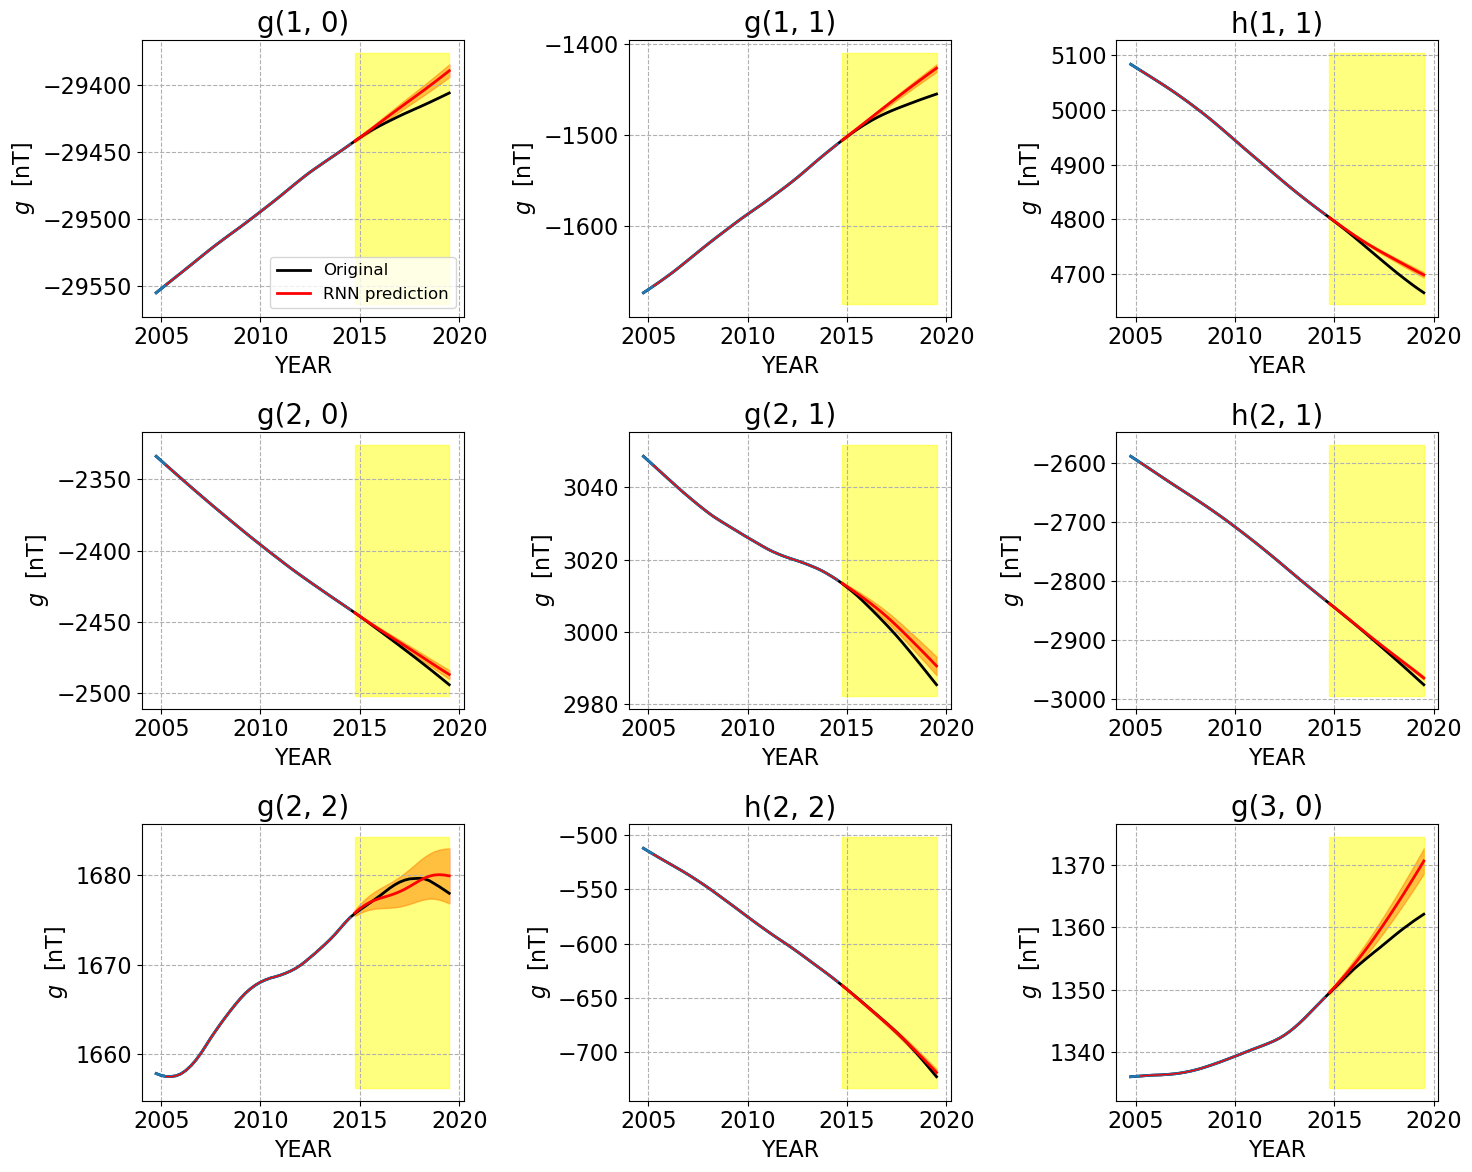

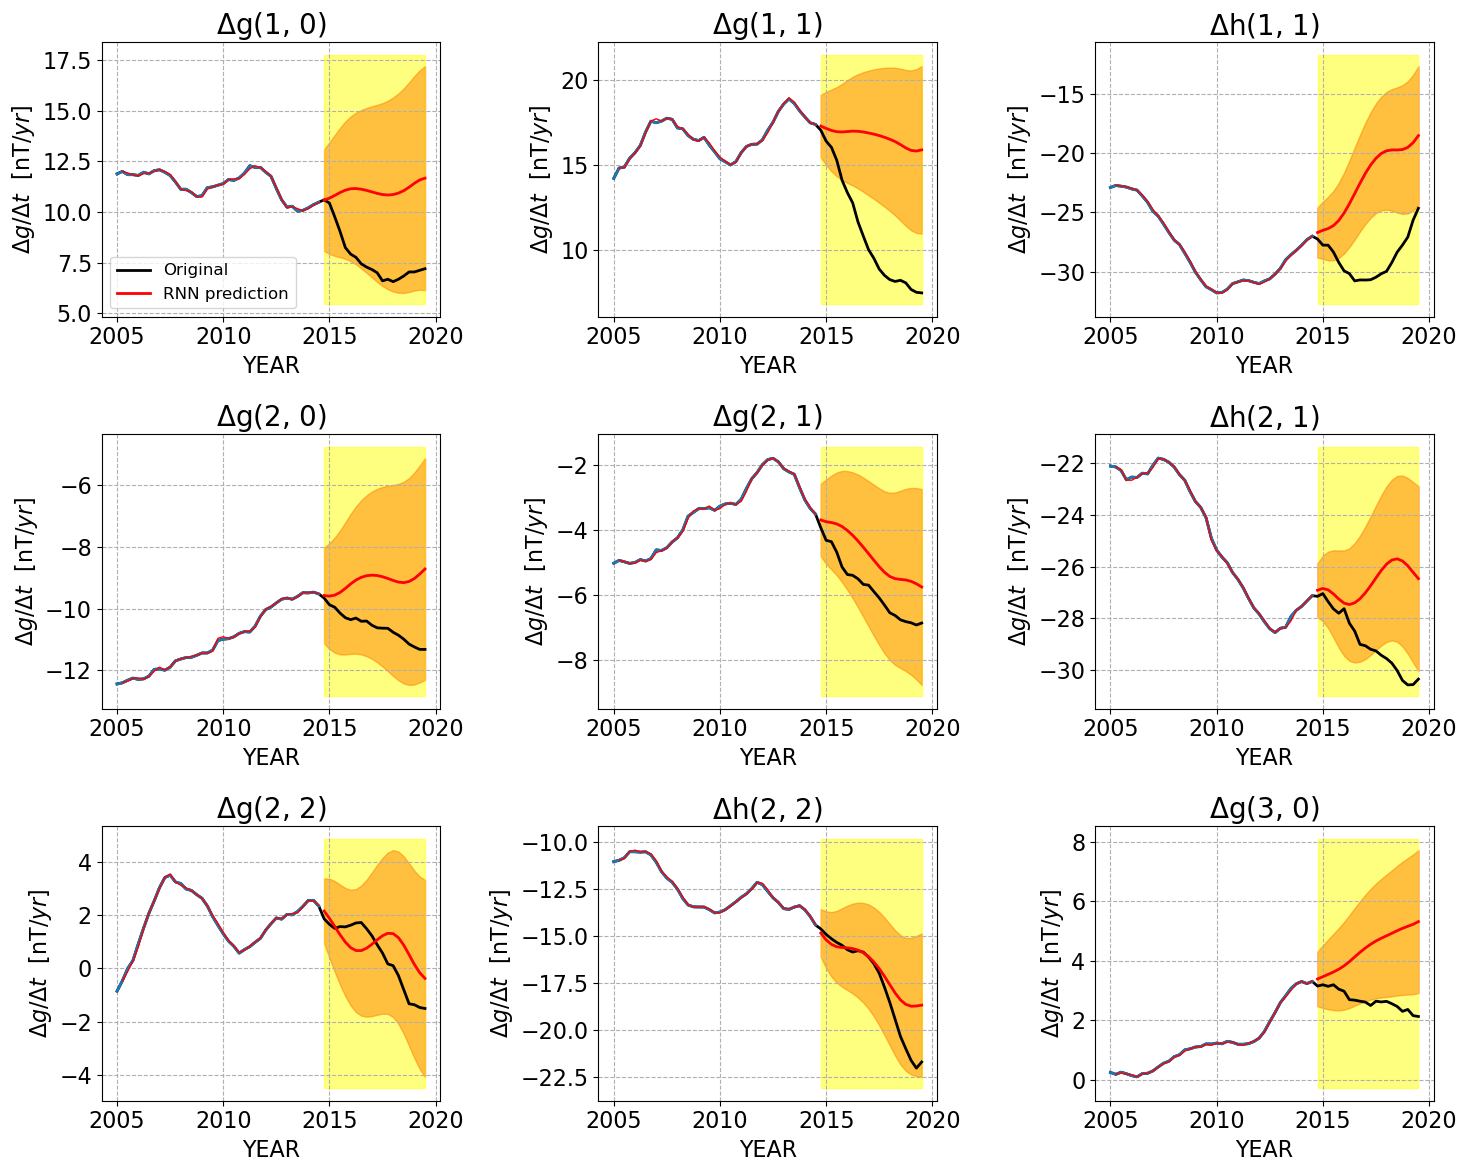

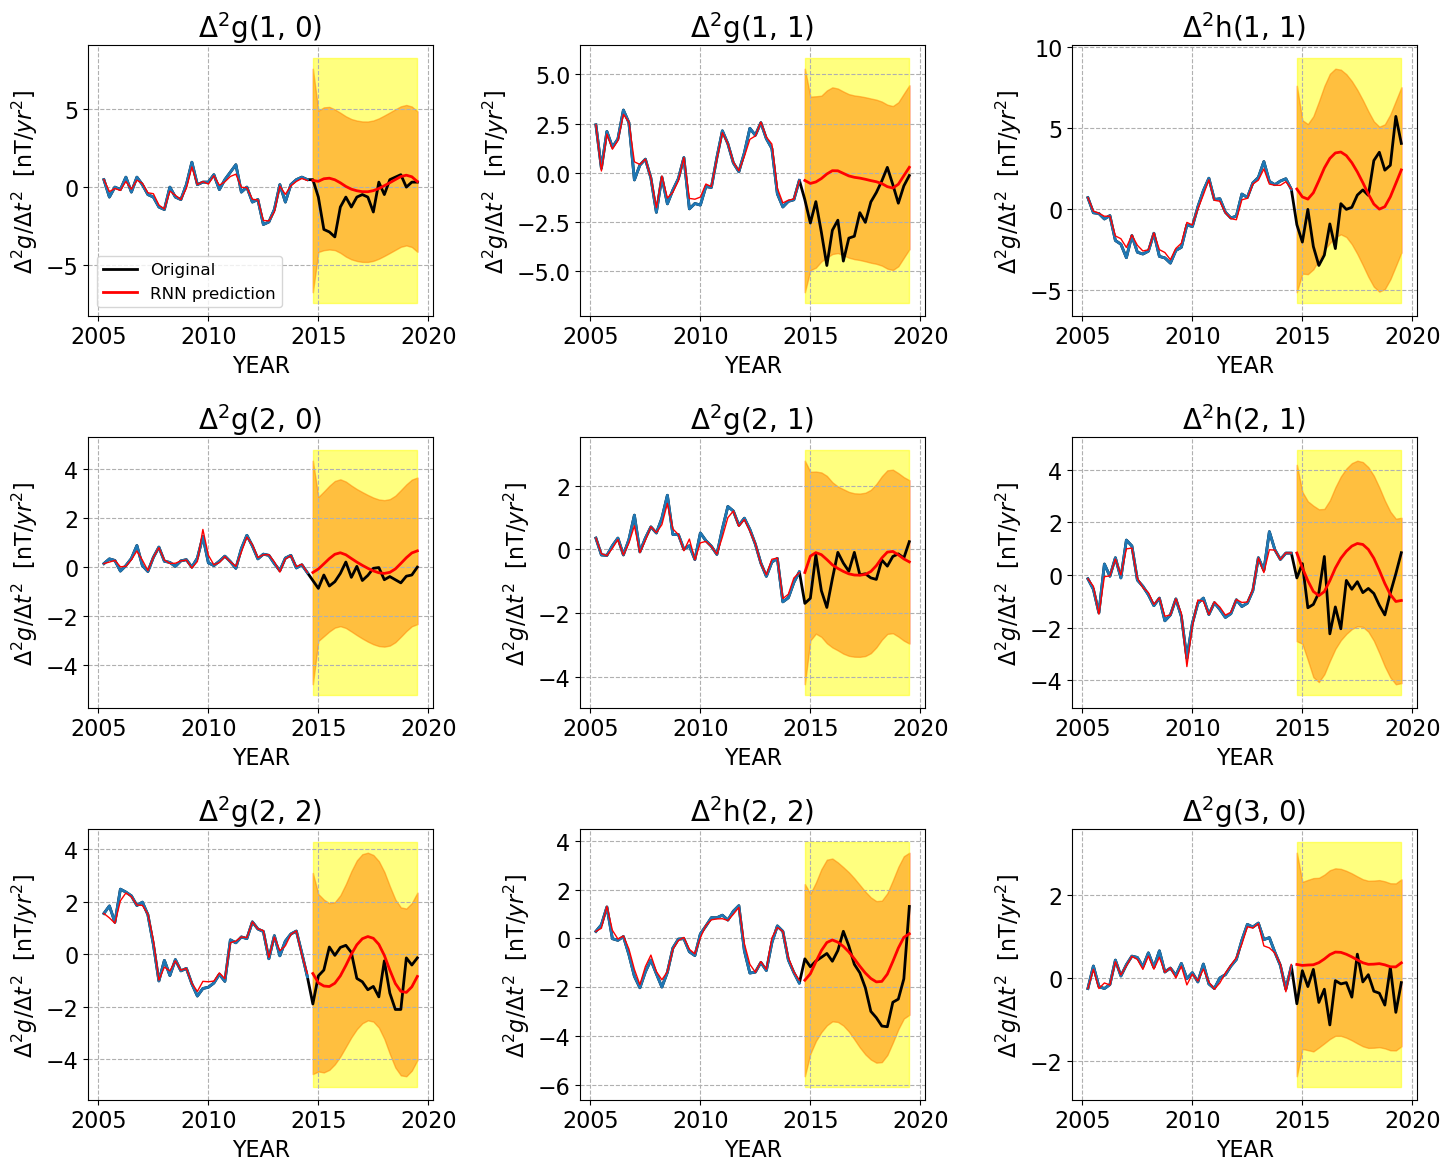

In [36]:
## Plot
# d0g ----------------------------------------------

fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

figlocs = [331, 332, 333, 334, 335, 336, 337, 338, 339]
axes = [plt.subplot(figloc) for figloc in figlocs]
coef_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, ax in enumerate(axes):
    idx = coef_idx[i]
    target = coef_df.columns[idx-1]
    
    # igrf2015 (comparison)
    # ax.plot   ( i2015LP[:,0], i2015LP[:,idx], color='green') # Linear Prediction with MF + 5 * Sv
    # ax.scatter( i2015MF[0],   i2015MF[idx],   color='green', label="IGRF-12 (2015 MF)", marker='*', s=200, edgecolors='black' )
    # igrf2020 (comparison)
    # ax.scatter( i2020MF[0],   i2020MF[idx],   color='olive', label="IGRF2020(MF)", marker='*', s=200, edgecolors='black' )

    ax.fill_between(valid[d].index,
                    d0g_valid[target] - np.sqrt(d0g_valid_cvar[target]), 
                    d0g_valid[target] + np.sqrt(d0g_valid_cvar[target]), 
                    color='red', alpha=0.5)

    plot_dg(ax, 0, d0g_train, d0g_valid, target)

    ax.set_ylabel(f"$g$  [nT]")
    ax.set_title(target, fontsize=20)

axes[0].legend(loc='lower right', fontsize=12)


plt.tight_layout()
# plt.savefig(savedir + f"4_d0g_{n_hidden}_tanh_EKF.png")
plt.show()

# d1g ----------------------------------------------

fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

figlocs = [331, 332, 333, 334, 335, 336, 337, 338, 339]
axes = [plt.subplot(figloc) for figloc in figlocs]
coef_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, ax in enumerate(axes):
    idx = coef_idx[i]
    target = coef_df.columns[idx-1] 

    # igrf (comparison)
    # ax.plot([2015, 2020], [i2015SV[idx], i2015SV[idx]], color='green', linestyle='--', label="IGRF-12 (2015 SV)")
    
    # ax.fill_between(train[d].index,
    #                 d1g_train[target] - np.sqrt(d1g_train_cvar[target]), 
    #                 d1g_train[target] + np.sqrt(d1g_train_cvar[target]), 
    #                 color='orange', alpha=0.5)

    ax.fill_between(valid[d].index,
                    d1g_valid[target] - np.sqrt(d1g_valid_cvar[target]), 
                    d1g_valid[target] + np.sqrt(d1g_valid_cvar[target]), 
                    color='red', alpha=0.5)
    
    plot_dg(ax, 1, d1g_train, d1g_valid, target)


    ax.set_ylabel(f"$\Delta g / \Delta t$  [nT/$yr$]")
    ax.set_title(r"$\Delta$" + target, fontsize=20)

axes[0].legend(loc='lower left', fontsize=12)

plt.tight_layout()
# plt.savefig(savedir + f"4_d1g_{n_hidden}_tanh_EKF.png")
plt.show()

# d2g ----------------------------------------------

fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

figlocs = [331, 332, 333, 334, 335, 336, 337, 338, 339]
axes = [plt.subplot(figloc) for figloc in figlocs]
coef_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, ax in enumerate(axes):
    idx = coef_idx[i]
    target = coef_df.columns[idx-1]

    # ax.fill_between(train[d].index,
    #                 d2g_train[target] - np.sqrt(d2g_train_cvar[target]), 
    #                 d2g_train[target] + np.sqrt(d2g_train_cvar[target]), 
    #                 color='orange', alpha=0.5)
    
    ax.fill_between(valid[d].index,
                    d2g_valid[target] - np.sqrt(d2g_valid_cvar[target]), 
                    d2g_valid[target] + np.sqrt(d2g_valid_cvar[target]), 
                    color='red', alpha=0.5)
    
    plot_dg(ax, 2, d2g_train, d2g_valid, target)

    ax.set_ylabel(f"$\Delta^{2} g / \Delta t ^{2}$  [nT/$yr^2$]")
    ax.set_title(r"$\Delta^2$" + target, fontsize=20)

axes[0].legend(loc='lower left', fontsize=12)

plt.tight_layout()
# plt.savefig(savedir + f"4_d2g_{n_hidden}_tanh_EKF.png")
plt.show()


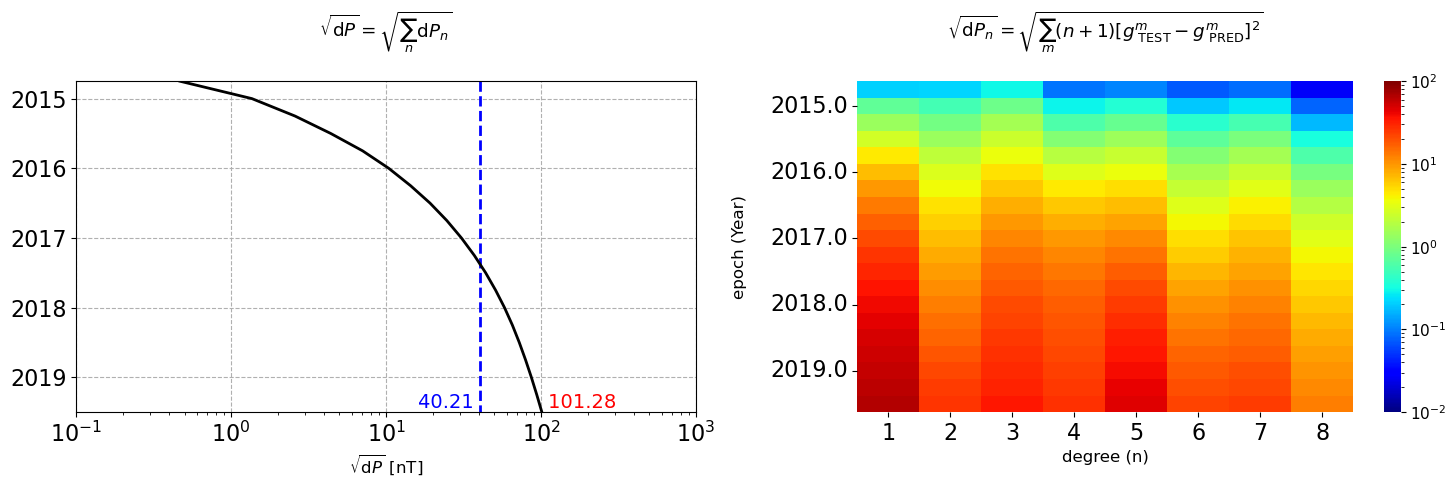

In [37]:
fig, ax = draw_dP(d0g_valid)
# plt.savefig(savedir + f"5_dP_diagram_{n_hidden}_tanh_EKF.png")
plt.show()

[(20, 195), (20, 20), (20,), (195, 20), (195,)]


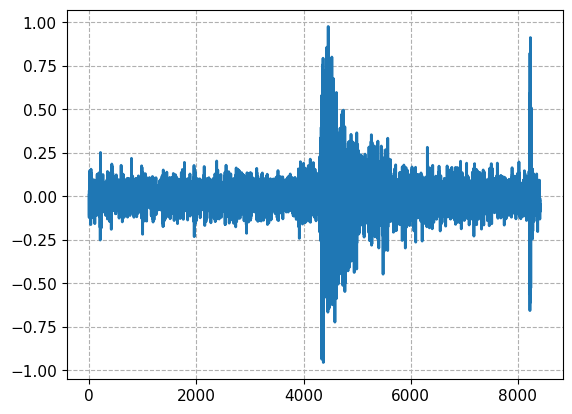

In [38]:
# print(noise)
plt.plot(W_hat)
print(Wshapes)

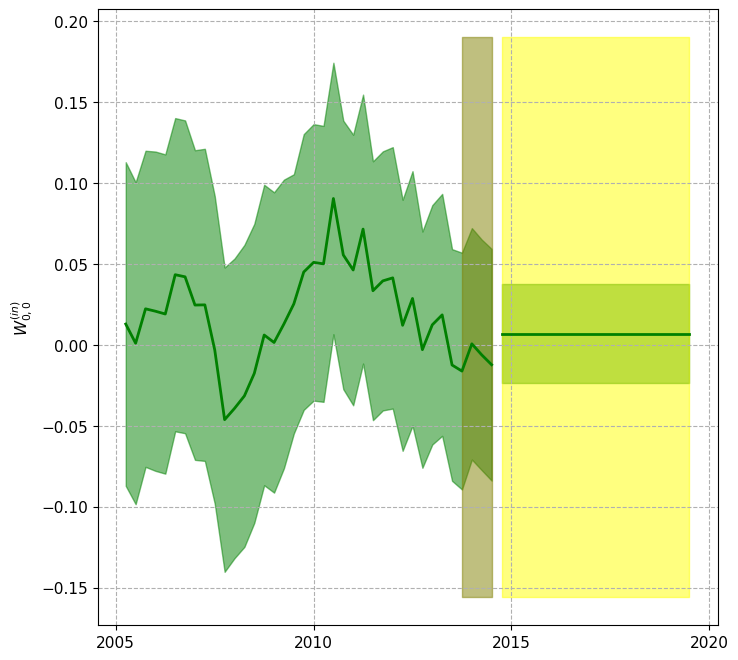

In [39]:
a = 0

W0  = np.array([Wa_memo[i][a]    for i in range(len(Wa_memo[:train_size[d]]))])
P00 = np.array([Pa_memo[i][a, a] for i in range(len(Pa_memo[:train_size[d]]))])

W0_hat  = W_hat[a]    * np.ones(test_size[d])
P00_hat = P_hat[a, a] * np.ones(test_size[d])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(train[d].index, W0, c="g")
ax.fill_between(train[d].index,
                W0 - np.sqrt(P00)/100, ###CAUTION!! P is too big!!
                W0 + np.sqrt(P00)/100, ###CAUTION!! P is too big!!
                color='green', alpha=0.5)

ax.plot(valid[d].index, W0_hat, c="g")
ax.fill_between(valid[d].index,
                W0_hat - np.sqrt(P00_hat)/100, ###CAUTION!! P is too big!!
                W0_hat + np.sqrt(P00_hat)/100, ###CAUTION!! P is too big!!
                color='green', alpha=0.5)

ymin, ymax = ax.get_ylim()
ax.fill_between(d2g_valid.index, ymin, ymax, color='yellow', alpha=0.5) # colorize forecast target period
ax.fill_between(d2g_train.index[-4:], ymin, ymax, color='olive', alpha=0.5) # colorize weight hat period

ax.set_xticks(np.arange(2005, 2021, 5))
ax.grid(True)

ax.set_ylabel(r"$W^{(in)}_{0, 0}$")

plt.show()

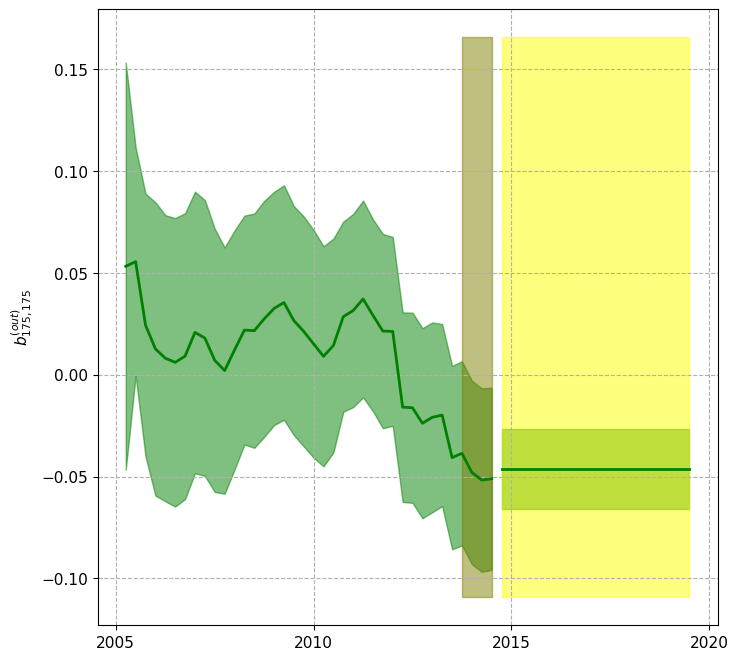

In [40]:
a = -1

W0  = np.array([Wa_memo[i][a]    for i in range(len(Wa_memo[:train_size[d]]))])
P00 = np.array([Pa_memo[i][a, a] for i in range(len(Pa_memo[:train_size[d]]))])

W0_hat  = W_hat[a]    * np.ones(test_size[d])
P00_hat = P_hat[a, a] * np.ones(test_size[d])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(train[d].index, W0, c="g")
ax.fill_between(train[d].index,
                W0 - np.sqrt(P00)/100, ###CAUTION!! P is too big!!
                W0 + np.sqrt(P00)/100, ###CAUTION!! P is too big!!
                color='green', alpha=0.5)

ax.plot(valid[d].index, W0_hat, c="g")
ax.fill_between(valid[d].index,
                W0_hat - np.sqrt(P00_hat)/100, ###CAUTION!! P is too big!!
                W0_hat + np.sqrt(P00_hat)/100, ###CAUTION!! P is too big!!
                color='green', alpha=0.5)

ymin, ymax = ax.get_ylim()
ax.fill_between(d2g_valid.index, ymin, ymax, color='yellow', alpha=0.5) # colorize forecast target period
ax.fill_between(d2g_train.index[-4:], ymin, ymax, color='olive', alpha=0.5) # colorize weight hat period

ax.set_xticks(np.arange(2005, 2021, 5))
ax.grid(True)

ax.set_ylabel(r"$b^{(out)}_{175, 175}$")

plt.show()

## 直前1年から $\hat{w}^*, \ \hat{P}^*$ を求めるのは不十分！5年くらいいる。